In [71]:
# i have tried the preprocessing and EDA from fast.ai (https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)
# i'm new to this (submission)and i haven't cleaned the notebook , but i know what i have done please check my 
# github (https://github.com/gdineshk6174)..


In [2]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [3]:
!pip install numpy pandas matplotlib.pyplot seaborn  --upgrade --quite


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --quite


In [4]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 25

In [5]:
from sklearn.metrics import mean_squared_log_error

In [6]:
!pip install xgboost lightgbm --upgrade --quiet

In [8]:
df = pd.read_csv('./TRAIN.csv', low_memory=False)

#### removing "#Order" feature 

In [9]:
df.drop('#Order', inplace=True, axis=1)

#### removing data records with Sales == 0 , as there were only 19 records it wont affect the data

In [10]:
df = df[df.Sales != 0]

In [11]:
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,45614.52


#### defining dependent variable

In [12]:
dep_var = "Sales"

In [13]:
df.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', 'Sales'],
      dtype='object')

#### add_datepart() which is a helper function ,it takes Dataframe and Date feature as input and creates  features from it like [“'Year', 'Month', 'Week', 'Day','Dayofweek', 'Dayofyear', etc

In [14]:
df = add_datepart(df, 'Date')

In [15]:
#handling date for test data
df_test = pd.read_csv('./TEST_FINAL.csv', low_memory=False)
df_test = add_datepart(df_test, 'Date')

## Preprocessing

#### procs is list of preparatory processing techniques needed to transform the data

#### Categorify : replaces categorical columns with a numeric categorical column
#### FillMissing : replaces missing values with median of the column and creates additional column which boolean in nature , where True is missing value and False is the opposite


In [16]:
procs = [Categorify , FillMissing]

#### splits : splits the data into training and validation , it should contain two lists with indexes of the data in them   
#### since this is a time series data we need to split train and validation bases on the timeframe chronologically. 
#### I have split the data such that the validation data resembles the test data meaning the have taken last two months of the traning data to be validation data.


In [17]:
cond = (df.Year<2019) | (df.Month<4)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

#### Cat is a list of feature names which are categorical in nature which is almost all of them in this case execpt “Elapsed”
#### Cont is a list of continuous feature in this case “Elapsed”


In [18]:
cont = ['Elapsed']
cat =['Store_id','Holiday','Year','Month','Week','Day','Dayofweek','Dayofyear','Store_Type',
  'Location_Type','Region_Code','Discount','Is_month_end','Is_month_start','Is_quarter_end',
  'Is_quarter_start','Is_year_end','Is_year_start']

#### TabluarPandas behaves like dataset objects which provides trian and valid attributes

In [19]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [20]:
len(to.train),len(to.valid)

(166060, 22261)

In [21]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [38]:
# randomforest from sklearn and the parameter values are from example casestudyies online

rf1 = RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.5,
        min_samples_leaf=5, oob_score=True,random_state=42)

# Fit the model
rf1.fit(xs, y)

rf1_train_preds = rf1.predict(xs)

# Compute MSLE on traing data
rf1_train_msle = mean_squared_log_error(y, rf1_train_preds)
print('The MSLE loss for the training set is  {}.'.format(rf1_train_msle))

rf1_val_preds = rf1.predict(valid_xs)

# Compute MSLE on validation data
rf1_val_msle = mean_squared_log_error(valid_y, rf1_val_preds)
print('The MSLE loss for the validation set is  {}.'.format(rf1_val_msle))

The MSLE loss for the training set is  0.025640391184805697.
The MSLE loss for the validation set is  0.127758110657176.


In [39]:
def rf_feat_importance(rf1, df):
    return pd.DataFrame({'cols':df.columns, 'imp':rf1.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [40]:
fi = rf_feat_importance(rf1, xs)
fi[:]

,cols,imp
8,Store_Type,0.312872
9,Location_Type,0.182902
11,Discount,0.130789
0,Store_id,0.084702
6,Dayofweek,0.065359
7,Dayofyear,0.048018
18,Elapsed,0.042679
1,Holiday,0.036516
5,Day,0.031584
4,Week,0.026465


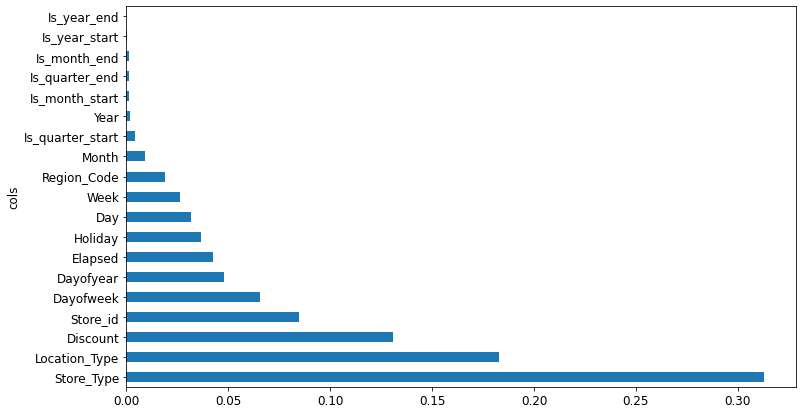

In [41]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:]);

#### removing features 

In [42]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

12

In [43]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

### Remove redundant features 
#### Cluster_columns(xs_imp) gives a chart which shows which pairs of features are most similar which are the ones that merged together far from the “root” of the tree at the left .
#### We drop one feature from the pair


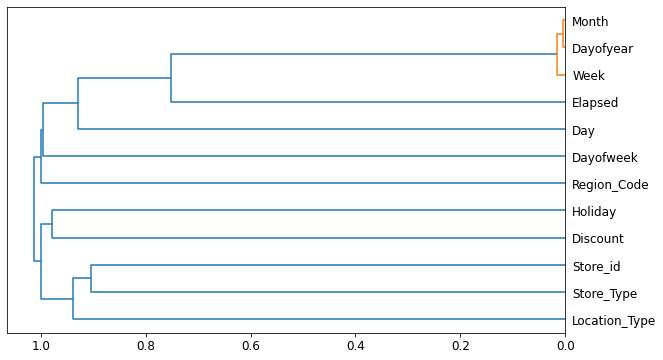

In [44]:
cluster_columns(xs_imp)

#### droping "Month" as it is very similar to "Dayofyear"

In [45]:
to_drop = ['Month']

In [46]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

### Finding Out of domain data: we don’t know whether test set is distributed the same way as training data or not and also which features reflect the difference 

#### inorder to do so we combine only independent variables from train and validation datasets and create a new dependent variable with 0 and 1  , where if the data is from training data and 1 if the data us from validation data 

In [47]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [50]:

rf1.fit(df_dom, is_valid)
rf_feat_importance(rf1, df_dom)

,cols,imp
6,Elapsed,0.899580
9,Week,0.075788
5,Dayofyear,0.023784
4,Dayofweek,0.000401
8,Day,0.000283
7,Holiday,0.000164
0,Store_Type,0.000000
1,Location_Type,0.000000
2,Discount,0.000000
3,Store_id,0.000000


#### o	Next use random forest train and calculate feature importance and select feature which have high values , which means the features with high values indicate they differ significantly with training and validation data ,in this case “Elapsed” ,“Week” and “Dayofyear”.

In [53]:
rf1.fit(xs_final, y)
print('orig', mean_squared_log_error(valid_y, rf1.predict(valid_xs_final))*1000)

for c in ('Elapsed','Week','Dayofyear'):
    rf1.fit(xs_final.drop(c,axis=1), y)
    print(c, mean_squared_log_error(valid_y, rf1.predict(valid_xs_final.drop(c,axis = 1)))*1000)

orig 137.9308831849982
Elapsed 82.03725376638086
Week 137.16455636460515
Dayofyear 139.12236620331524


#### Now we compare the MSLE score by dropping one feature at a time among the 3 with the original score
#### When “Elapsed” was removed the MSLE score was 82.03 , similarly for “Week”  was 137.16 and “Dayofyear” was 139.12. so it is ideal to remove two features among them to get better MSLE score , I have chosen “Elapsed” as it gives lowest score and “Dayofyear” becoz there isn’t much difference between “Dayofyear” and “Week” (look at the cluster chart)and also I felt the pattern with “Week” feature would be much better.


In [61]:
time_vars = ['Elapsed', 'Dayofyear']

#### Next I droped the time variables “Elapsed” and “Dayofyear” from traiing and validation sets

In [62]:
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

### Random forest parameter values
#### One of the important properties of random forest is that they aren’t very sensitive to the hyperparameters choices such as max_features.
#### So what I did was create a range of values for each hyperparameter and fir the model with one parameter at a time and observe its impact on the train and validation msle values.
#### And then i selected hypermeter values which has low validation msle score.
#### Although it necessarily doesn’t mean that by selecting all the parameter values with low msle score gives the best MSLE score with put together but since we are using  Randomforest , as said earlier, randomforest isn’t that sensitive to parameter tuning but if  had I used any other algorithm I would use GridSeachCV from sklearn to find the optimal values for the hyperparameters.


In [65]:
def test_params(**params):  
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(xs_final_time, y)
    train_msle = mean_squared_log_error(y, model.predict(xs_final_time))
    val_msle = mean_squared_log_error(valid_y, model.predict(valid_xs_time))
    return train_msle, val_msle

In [66]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_msle, val_msle = test_params(**params)
        train_errors.append(train_msle)
        val_errors.append(val_msle)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('MSLE')
    plt.legend(['Training', 'Validation'])

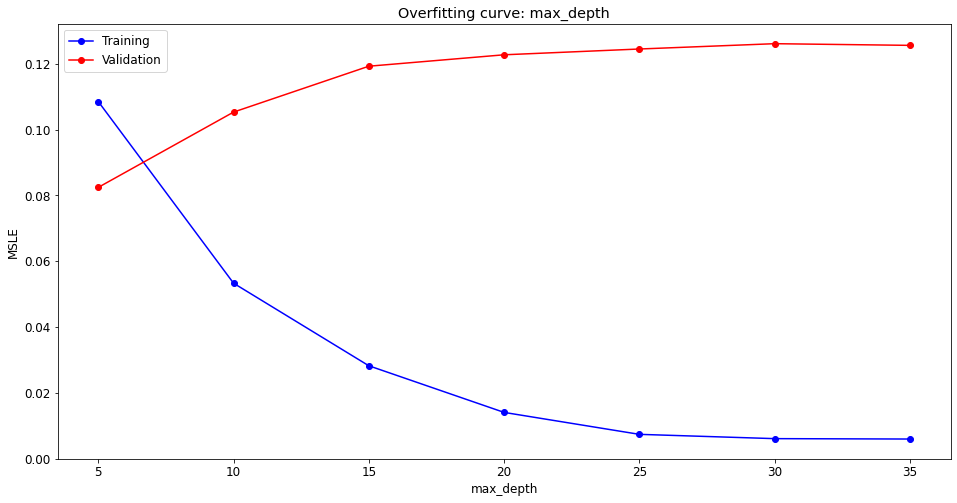

In [67]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

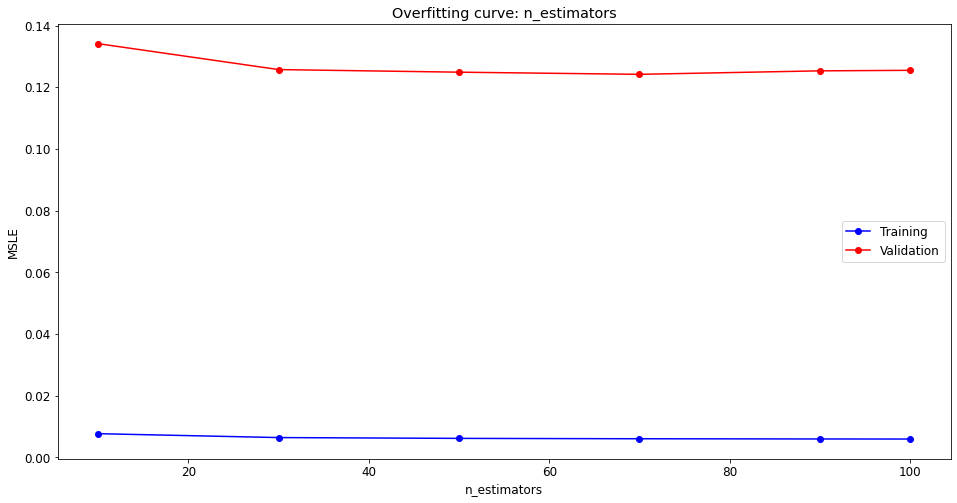

In [68]:
test_param_and_plot('n_estimators', [10, 30, 50, 70, 90, 100])

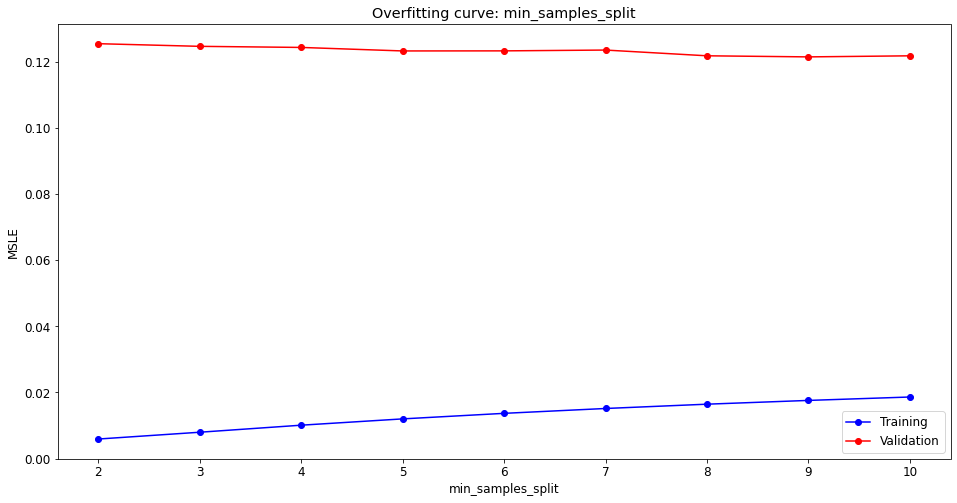

In [69]:
test_param_and_plot('min_samples_split', [2, 3, 4, 5, 6, 7, 8, 9, 10])

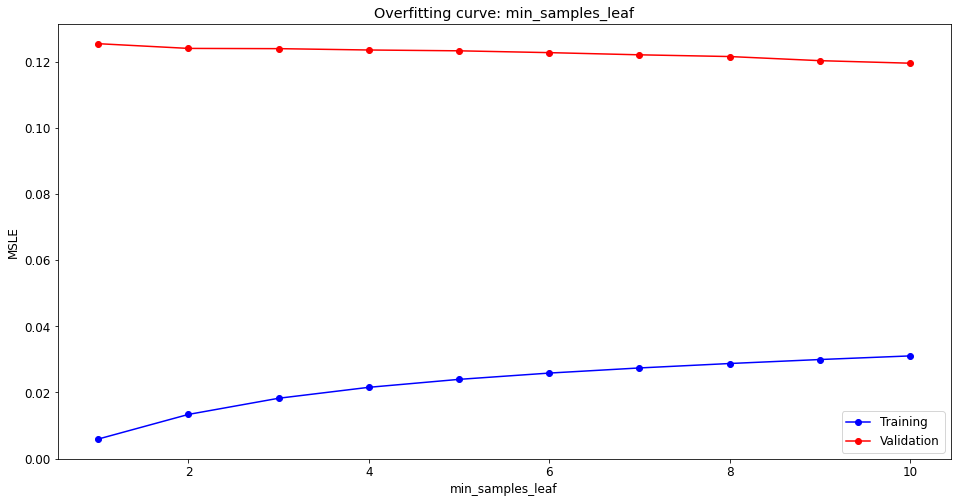

In [70]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

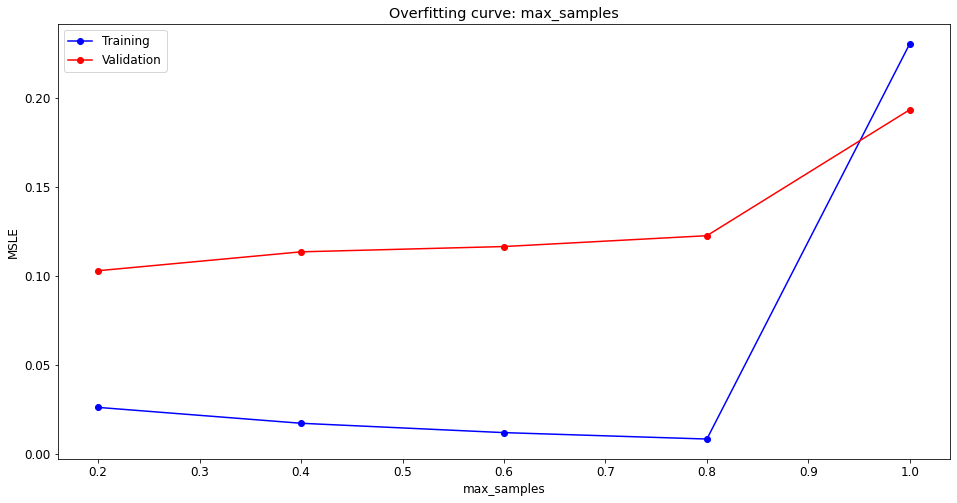

In [71]:
test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1])

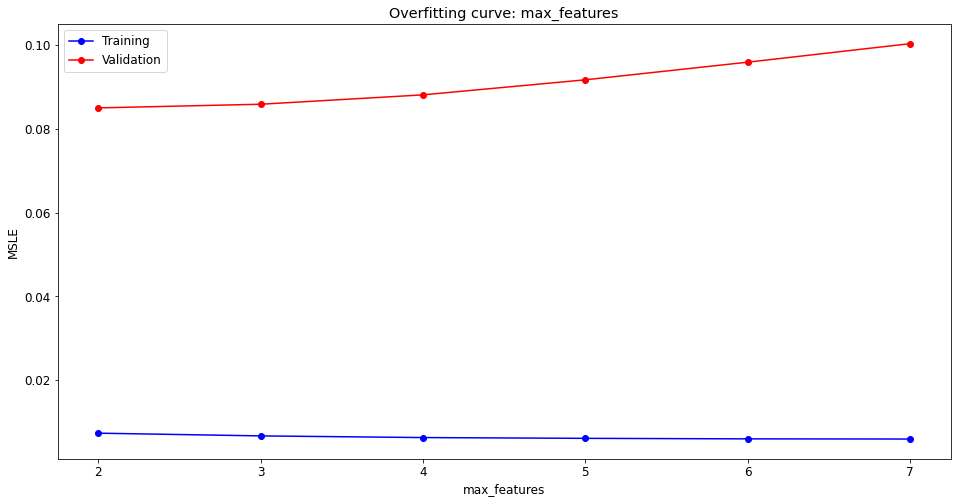

In [72]:
test_param_and_plot('max_features', [2, 3, 4, 5, 6, 7])

In [75]:
# Create the model
rf1 = RandomForestRegressor(n_jobs=-1, max_depth=30, n_estimators=60, min_samples_split=8,
                            min_samples_leaf=10, max_samples=0.8, max_features=6,  random_state=42)

# Fit the model
rf1.fit(xs_final_time, y)

rf1_train_preds = rf1.predict(xs_final_time)

# Compute MSLE on traing data
rf1_train_msle = mean_squared_log_error(y, rf1_train_preds)
print('The MSLE loss for the training set is  {}.'.format(rf1_train_msle))

rf1_val_preds = rf1.predict(valid_xs_time)

# Compute MSLE on validation data
rf1_val_msle = mean_squared_log_error(valid_y, rf1_val_preds)
print('The MSLE loss for the validation set is  {}.'.format(rf1_val_msle))


The MSLE loss for the training set is  0.034351386747291046.
The MSLE loss for the validation set is  0.08857037362011123.


xs_final_time.shape

#### Next we transform the test data similar to that of the training data by following the same steps and remove the features which are not required.
#### Next we use the trained model to predict the “Sales” for the test data.


In [53]:
df_test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,T1188341,171,S4,L2,R3,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
1,T1188342,172,S1,L1,R1,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
2,T1188343,173,S4,L2,R1,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
3,T1188344,174,S1,L1,R4,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09
4,T1188345,170,S1,L1,R2,0,No,2019,6,22,1,5,152,False,True,False,False,False,False,1.559347e+09


In [54]:
df_test.shape

(22265, 20)

In [55]:
df_test['Sales'] = 0

In [56]:
df_test.shape

(22265, 21)

In [57]:
to_test = TabularPandas(df_test, procs, cat, cont, y_names=dep_var)

In [58]:
test_xs_imp = to_test.xs[to_keep]

In [59]:
test_xs_final = test_xs_imp.drop(to_drop, axis=1)

In [60]:
test_xs_final.shape

(22265, 11)

In [61]:
test_xs_time = test_xs_final.drop(time_vars, axis=1)

In [63]:
test_xs_time .shape

(22265, 9)

In [64]:
df_rf_red = pd.DataFrame()

In [65]:
df_rf_red['ID'] = df_test['ID']
df_rf_red['Sales'] = rf1.predict(test_xs_time)

In [66]:
df_rf_red.head()

,ID,Sales
0,T1188341,69223.252300
1,T1188342,45813.196296
2,T1188343,90449.531260
3,T1188344,49556.304318
4,T1188345,47915.670069


In [68]:
header = ["ID", "Sales"]

In [69]:
df_rf_red.to_csv('./rf_tree_red_final.csv', columns = header, index=False)

In [70]:
pd.read_csv('./rf_tree_red_final.csv', low_memory=False).head()

,ID,Sales
0,T1188341,69223.252300
1,T1188342,45813.196296
2,T1188343,90449.531260
3,T1188344,49556.304318
4,T1188345,47915.670069
